In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import math

# 查看MPS是否可用
print(torch.backends.mps.is_available())
# 设置float32
torch.set_default_dtype(torch.float32)

True


In [3]:
random_torch = torch.rand(4, 4)
random_torch

tensor([[0.8415, 0.9740, 0.7510, 0.2068],
        [0.5055, 0.4642, 0.8886, 0.8748],
        [0.1631, 0.3185, 0.4220, 0.1893],
        [0.3228, 0.7128, 0.3392, 0.6722]])

# Embedding

## 定义TokenEmbedding类
- 作用:用于通过输入词表索引来转换成对应的一个embedding

In [6]:
# 将输入的词汇表索引转换为指定维度的Embedding
class TokenEmbedding(nn.Embedding):
  """
    :vocab_size 词表大小
    :d_model embedding维度
    :padding_idx 填充索引
  """
  def __init__(self, vocab_size, d_model):
    super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

## 定义Position Embedding类
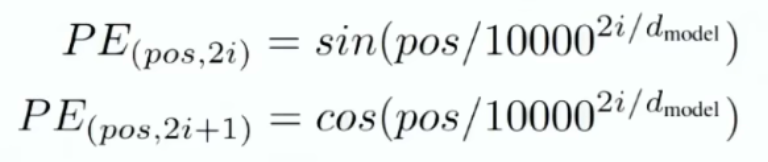

In [7]:
# 通过位置编码,计算输入序列的每一个词,它生成的正弦和余弦的一个位置编码,以便我们的模型去利用到这个词的位置信息
class PositionEmbedding(nn.Module):
  """
    :d_model embedding维度
    :max_len 最大序列长度
    :device 设备
  """
  def __init__(self, d_model, max_len, device):
    super(PositionEmbedding, self).__init__()
    self.encoding = torch.zeros(max_len, d_model, device=device)
    self.encoding.requires_grad = False  # 位置编码不需要梯度计算
    # tensor.unsqueeze(dim) 在指定维度上增加一个维度
    pos = torch.arange(0, max_len, device=device).float().unsqueeze(dim=1) # (max_len, 1)
    _2i = torch.arange(0, d_model, step=2, device=device).float()
    # 计算位置编码,奇数和偶数位置分别计算编码
    self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
    self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
  
  def forward(self, x):
    batch_size, seq_len = x.size() # 获取输入的batch_size和序列长度
    return self.encoding[:seq_len, :]  # 返回对应长度的编码

In [8]:
class TransformerEmbedding(nn.Module):
  """
    :vocab_size 词表大小
    :d_model embedding维度 / 模型的维度
    :max_len 最大序列长度
    :drop_prob dropout概率
    :device 设备
  """
  def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
    super(TransformerEmbedding, self).__init__()
    self.token_embedding = TokenEmbedding(vocab_size, d_model)
    self.position_embedding = PositionEmbedding(d_model, max_len, device)
    self.drop_out = nn.Dropout(p=drop_prob)
  
  def forward(self, x):
    # 将词嵌入和位置嵌入相加,并进行缩放
    tok_emb = self.token_embedding(x)
    pos_emb = self.position_embedding(x)
    return self.drop_out(tok_emb + pos_emb)

# 整合

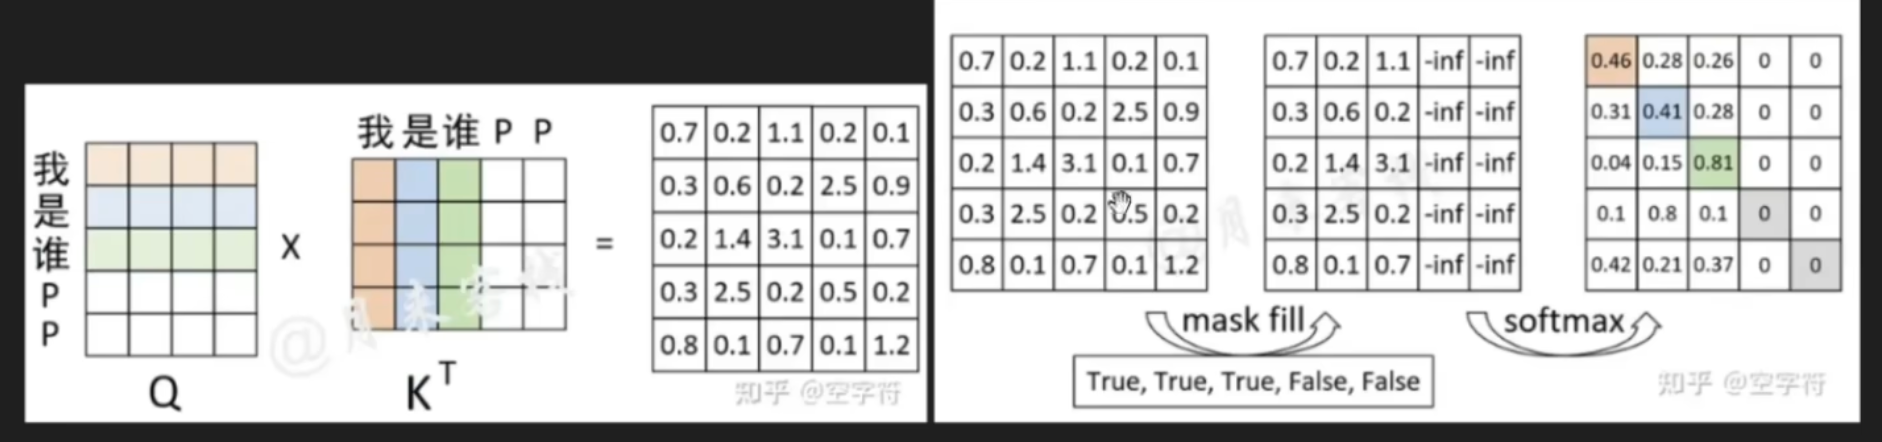
> 一段话中可能有不同程度的句子,前后句子长度不一致,这时候为了对它们两个做一个计算,就需要做padding,这时候就是要masked掉的

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
import math

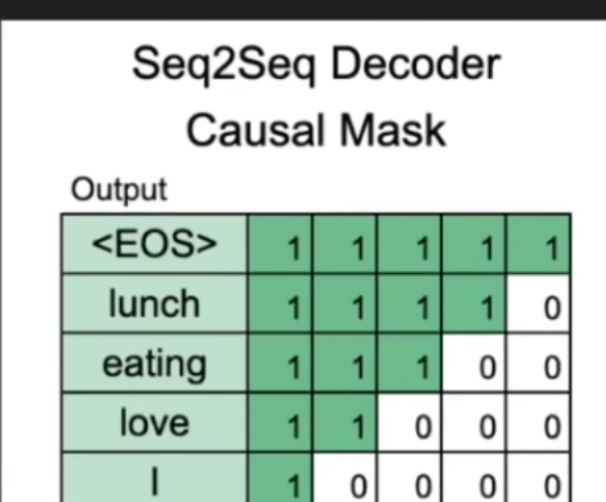m

In [12]:
class Transformer(nn.Module):
  """
    :src_pad_idx 源语言填充索引
    :trg_pad_idx 目标语言填充索引
    :enc_voc_size 源语言词表大小
    :dec_voc_size 目标语言词表大小
    :d_model 模型维度
    :max_len 最大序列长度
    :n_heads 多头注意力头数
    :ffn_hidden 前馈神经网络隐藏层维度
    :n_layers 编码器和解码器层数
    :drop_prob dropout概率
    :device 设备
  """
  def __init__(self, src_pad_idx, trg_pad_idx, enc_voc_size, dec_voc_size, \
    d_model, max_len, n_heads, ffn_hidden, n_layers, drop_prob, device):
    super(Transformer, self).__init__()
    self.encoder = Encoder(enc_voc_size, max_len, d_model,\
      ffn_hidden, n_heads, n_layers, drop_prob, device)
    self.decoder = Decoder(dec_voc_size, max_len, d_model,\
      ffn_hidden, n_heads, n_layers, drop_prob, device)
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device
  """
    创建填充掩码
    :q 查询序列
    :k 关键序列
    :pad_idx 填充索引
    :pad_idx_k 关键序列填充索引
  """
  def make_pad_mask(self, q, k, pad_idx_q, pad_idx_k):
    len_q, len_k = q.size(1), k.size(1)
    q = q.ne(pad_idx_q).unsqueeze(1).unsqueeze(3)  # (batch_size, 1, len_q, 1)
    q = q.repeat(1, 1, 1, len_k)  # (batch_size, 1, len_q, len_k)
    k = k.ne(pad_idx_k).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, len_k)
    k = k.repeat(1, 1, len_q, 1)  # (batch_size, 1, len_q, len_k)
    mask = q & k  # (batch_size, 1, len_q, len_k)
    return mask
  # 因果掩码
  def make_casual_mask(self, q, k):
    # 生成下三角矩阵
    mask = torch.trill(torch.ones((len_q, len_k), device=self.device)).type(torch.BoolTensor)
    return mask
  
  """
    前向传播
    :src 源语言输入序列
    :trg 目标语言输入序列
  """
  def forward(self, src, trg):
    # 创建编码器填充掩码
    src_mask = self.make_pad_mask(src, src, self.src_pad_idx, self.src_pad_idx)
    # 创建解码器填充掩码 , 解码器因果掩码
    trg_mask = self.make_pad_mask(trg, trg, self.trg_pad_idx, self.src_pad_idx) * self.make_casual_mask(trg, trg)
    # 编码器输出
    enc_out = self.encoder(src, src_mask)
    # 解码器输出
    dec_out = self.decoder(trg, enc_out, trg_mask, src_mask)
    return dec_out
    